In [81]:
import os

import rasterio as rio
from rasterio.mask import mask

from glob import glob

import matplotlib.pyplot as plt

import pandas as pd
from shapely import geometry

import geojson
import json


import numpy as np

import gcsfs
GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

import seaborn as sns

import xarray as xr

from dask.distributed import Client
import dask

from functools import partial
import pyproj
from shapely.ops import transform

import cartopy.crs as ccrs

from functools import partial
import pyproj
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init='epsg:3857')) # destination coordinate system



In [2]:
client = Client()

## Process Sentinel3 Chlorophyll

In [115]:
imagery_root = '/tmp/nepacs3/'
image_files = glob(os.path.join(imagery_root, "*/*nn*.tif"))

In [116]:
def get_date_from_file(file):
    return(pd.to_datetime(os.path.splitext(file)[0].split('-')[1]))

In [117]:
dates = list(map(get_date_from_file, image_files))

In [118]:
xr_ds = [
    rio.open(image_file) for image_file in image_files
]

In [119]:
len(xr_ds)

48

**Crop** each one to a buffered zone 'round the chosen isolate (id:240, the nepac one)

In [120]:
plankton = pd.read_csv(
    '../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv',
    engine='python'
)

In [121]:
isolate_code = 240
isolate = plankton[plankton['isolate.code'] == isolate_code]

In [122]:
isolate

,isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,...,minqual,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis
169,240,Northeast Pacific,45.0,-145.0,marine,Pseudo-nitzschia granii,Pseudo-nitzschia granii,NaN,NaN,NaN,...,good,good,good,-4.141825,-0.000537,1.0,1.0,1.0,1.0,1.0


In [123]:
project_merc = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init='epsg:3857')) # mercator, to compute area buffer

project_wgs = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:3857'), # source coordinate system
    pyproj.Proj(init='epsg:4326')) # mercator, to compute area buffer



In [124]:
isolate_point_wgs = geometry.Point(
    isolate['isolation.longitude'],
    isolate['isolation.latitude']
)

In [125]:
isolate_point_meters = transform(project, isolate_point_wgs)

In [126]:
merc_500m_buffer = isolate_point_meters.buffer(20000)

In [127]:
clipped_data = []
for ds in xr_ds:
    try:
        clipped_data.append(rio.mask.mask(ds, [merc_500m_buffer], crop=True))
    except Exception as e:
        print(e)
        clipped_data.append(e)
    
    

In [128]:
len(clipped_data)

48

Turn them all to masked arrays

In [129]:
ma_clipped = []
for data in clipped_data:
    print(type(data))
    if isinstance(data, Exception): 
        ma_clipped.append(data)
        continue
        
    _ma = np.ma.MaskedArray(
        data = data[0][0], 
        mask = (data[0][1] == 0)
    )
    ma_clipped.append(_ma)

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


## Compute Mean chl-$\alpha$

In [130]:
chl = []
for ma in ma_clipped:
    print(isinstance(ma, Exception))
    if isinstance(ma, Exception): 
        chl.append(np.nan)
        continue
    chl.append(np.mean(ma))
    

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [131]:
chl_df = pd.DataFrame({
    'date': dates,
    'chl': chl
})

In [132]:
chl_df.loc[chl_df.chl.apply(lambda x: isinstance(x, np.ma.core.MaskedConstant)), 'chl'] = np.nan

In [133]:
chl_df=chl_df.sort_index()

In [134]:
chl_df.index

RangeIndex(start=0, stop=48, step=1)

(array([736177., 736191., 736208., 736222., 736238., 736252., 736269.,
        736283.]),
 <a list of 8 Text xticklabel objects>)

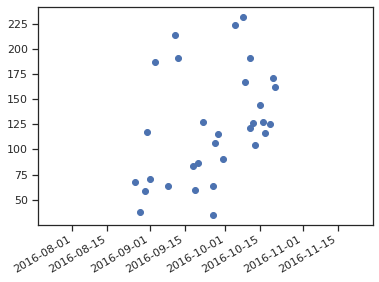

In [135]:
plt.scatter(chl_df.date, chl_df.chl)
plt.xticks(rotation=30, ha='right')

In [136]:

len(chl_df[~chl_df.chl.isna()])

31

## Can we look at performance around this time?

In [137]:
isolate_performance_perf = xr.open_zarr("../data/isolate_mhw_performance.zarr/isolate_mhw_performance.zarr/")

In [138]:
mhw_performance = isolate_performance_perf.sel(
    isolate=isolate_code, 
    time=slice(chl_df.date.min(), chl_df.date.max())
)

In [139]:
mhw_performance.time.min()

<xarray.DataArray 'time' ()>
array('2016-08-26T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    isolate  int64 240
    lat      float32 dask.array<chunksize=(), meta=np.ndarray>
    lon      float32 dask.array<chunksize=(), meta=np.ndarray>

(array([736208., 736215., 736222., 736229., 736238., 736245., 736252.,
        736259.]),
 <a list of 8 Text xticklabel objects>)

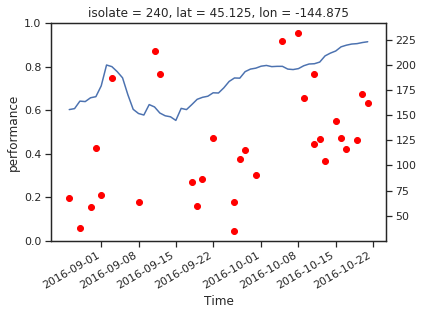

In [140]:
mhw_performance.performance.plot()
plt.ylim([0, 1])
ax2 = plt.twinx()
ax2.scatter(chl_df.date, chl_df.chl, color='red')
plt.xticks(rotation=30, ha='right')

In [141]:
chl_df['date_delta'] = (chl_df.reset_index()['date'] - chl_df.reset_index()['date'].min())  / np.timedelta64(1,'D')

AttributeError: 'Dataset' object has no attribute 'perf'

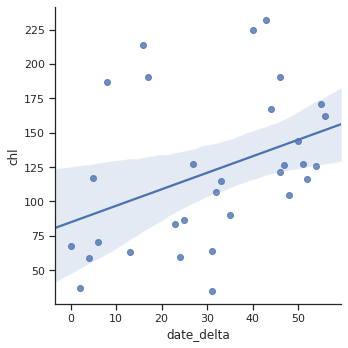

In [142]:
fg = sns.lmplot(x='date_delta', y='chl', data=chl_df.reset_index().dropna(), )
sns.scatterplot(mhw_performance.perf)

In [143]:
fg.axes[0][0]

In [144]:
chl_df[''(chl_df.reset_index()['date'] - chl_df.reset_index()['date'].min())  / np.timedelta64(1,'D')

SyntaxError: unexpected EOF while parsing (<ipython-input-144-ab7acb318658>, line 1)

In [145]:
def lowess_smooth(data):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    
    endog = data.values
    exog = data.index.values
    
    smooth = lowess(endog, exog)
    index, xformed = np.transpose(smooth)

    return pd.Series(xformed, index=pd.to_datetime(index)) 

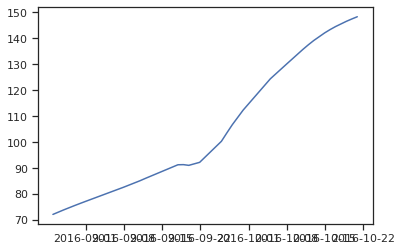

In [146]:
plt.plot(lowess_smooth(chl_df.dropna(subset=['chl']).set_index('date').chl))

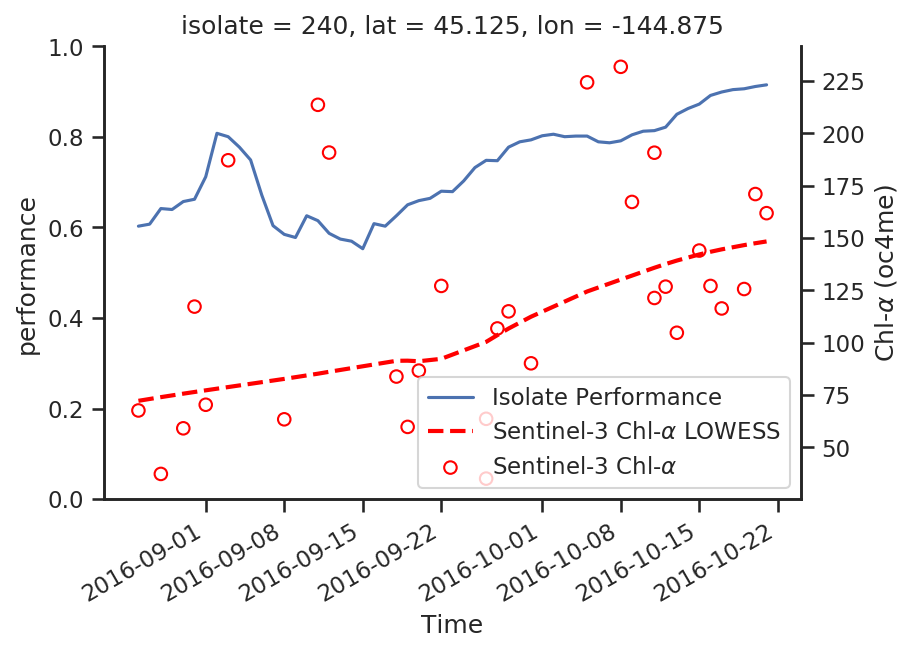

In [147]:
plt.figure(dpi=150)
sns.set(style='ticks')
ax1 = plt.axes()
_p0 = mhw_performance.performance.plot(label='Isolate Performance', ax=ax1)
ax1.set_ylim([0, 1])
ax2 = ax1.twinx()
_p1 = ax2.scatter(chl_df.date, chl_df.chl, color='none', alpha=1, edgecolor='red', label=r'Sentinel-3 Chl-$\alpha$')
plt.xticks(rotation=30, ha='right')
ax2.set_ylabel(r"Chl-$\alpha$ (oc4me)")
_p2 = plt.plot(
    lowess_smooth(chl_df.dropna(subset=['chl']).set_index('date').chl),
    linewidth=2, color='red', linestyle='--',
    label=r'Sentinel-3 Chl-$\alpha$ LOWESS'
)
    
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')
sns.despine(right=False)
plt.savefig("nepac_s3_validate.pdf", bbox_inches='tight')

## Create Paired plot

In [82]:
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

In [87]:
selected_sst = oisst.sel(
    lat = mhw_performance.lat.values.item(),
    lon = mhw_performance.lon.values.item(), 
    time = mhw_performance.time
)

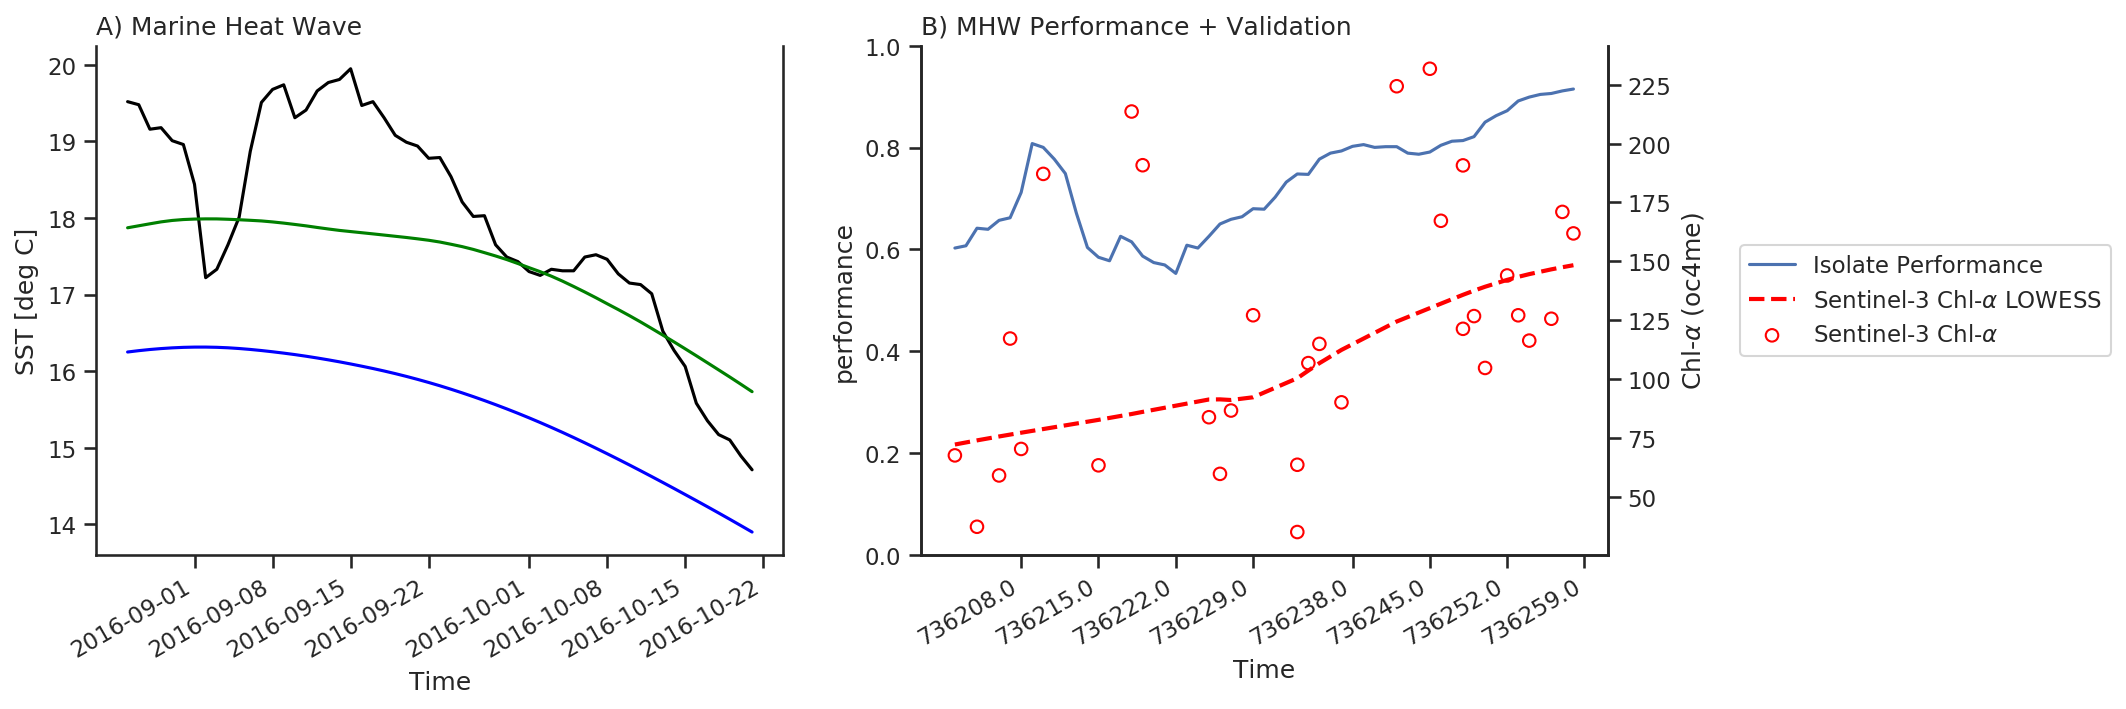

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), dpi=150)

sst_ax = axes[0]

selected_sst.sst.plot(ax=sst_ax, color='black')
mhw_performance.clim_seas.plot(ax=sst_ax, color='blue')
mhw_performance.clim_thresh.plot(ax=sst_ax, color='green')
sst_ax.set_ylabel("SST [deg C]")
sst_ax.set_title("")
sst_ax.set_title("A) Marine Heat Wave", loc='left')

chl_ax = axes[1]
_p0 = mhw_performance.performance.plot(label='Isolate Performance', ax=chl_ax)
chl_ax.set_ylim([0, 1])
chl_twinax = chl_ax.twinx()
_p1 = chl_twinax.scatter(chl_df.date, chl_df.chl, color='none', alpha=1, edgecolor='red', zorder=-1,  label=r'Sentinel-3 Chl-$\alpha$')
chl_ax.set_xticklabels(chl_ax.get_xticks(), rotation=30, ha='right')
chl_twinax.set_ylabel(r"Chl-$\alpha$ (oc4me)")
_p2 = chl_twinax.plot(
    lowess_smooth(chl_df.dropna(subset=['chl']).set_index('date').chl),
    linewidth=2, color='red', linestyle='--',
    label=r'Sentinel-3 Chl-$\alpha$ LOWESS'
)
    
lines, labels = chl_ax.get_legend_handles_labels()
lines2, labels2 = chl_twinax.get_legend_handles_labels()
chl_twinax.legend(lines + lines2, labels + labels2, loc='center right', fancybox=True, bbox_to_anchor=(1.75, 0.5))

chl_ax.set_title("")
chl_ax.set_title("B) MHW Performance + Validation", loc='left')

sns.despine(right=False)
plt.savefig("nepac_s3_combined.pdf", bbox_inches='tight')

Timestamp('2016-08-26 00:00:00')